In [1]:
import numpy as np 
import matplotlib.pyplot as plt # 図の作成環境のロード
from matplotlib import cm # カラーマップ
import time # 計算時間計測プロファイリング用

# 図のテキストにLaTeXを使う
plt.rcParams['text.usetex'] = True

# numbaで高速化
from numba import double
from numba.decorators import jit

In [2]:
# parameters 
CFLv=0.3
CFLk=0.3
Uwall=0.01
nu=1.e-6
Dens=1.e3
Tbc_H = 1.0
Tbc_L = 0.0
kappa=1.e-5
Lx=0.1e0
Ly=Lx

Nx=41
Ny=43

# for solver
accel = 1.925e0
err_tol = 1.e-6
tiny = 1.e-20

In [3]:
# set grid 
dx=Lx/np.float(Nx+1)
dy=Ly/np.float(Ny+1)

x=np.array(np.zeros(Nx+2),dtype=np.float64)
xc=np.array(np.zeros(Nx+1),dtype=np.float64)
y=np.array(np.zeros(Ny+2),dtype=np.float64)
yc=np.array(np.zeros(Ny+1),dtype=np.float64)

# set uniform grid
x[0]=0.0
for i in range(1,Nx+2):
    x[i]=x[i-1]+dx; # raw grid
    xc[i-1]=0.5*(x[i-1]+x[i])/Lx # scaled grid centre
#end of for
y[0]=0.0
for i in range(1,Ny+2):
    y[i]=y[i-1]+dy; # raw grid 
    yc[i-1]=0.5*(y[i-1]+y[i])/Lx # scaled grid centre
#end of for

dt = min(CFLv*dx/Uwall, CFLk*dx*dx/nu)
endT=50
Nt = int(endT*Lx/Uwall/dt)

dx2=(dx*dx) 
dy2=(dy*dx) 
dtx2=dt/(dx*dx) 
dty2=dt/(dy*dx)


In [4]:
# variables 
u=np.zeros([Ny+1, Nx+2],dtype=np.float64)
v=np.zeros([Ny+2, Nx+1],dtype=np.float64)
p=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T=np.zeros([Ny+1, Nx+1],dtype=np.float64)

uaux=np.zeros([Ny+1, Nx+2],dtype=np.float64)
vaux=np.zeros([Ny+2, Nx+1],dtype=np.float64)
dive=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T0=np.zeros([Ny+1, Nx+1],dtype=np.float64)

In [8]:
# Fortran 配列から Namba配列にするには: (i,j) --> [j,i] に変更, 改行(&) --> バックスラッシュ (/)に変更
# 改行コード(/)のあとにスペースが有ると エラーが出る．
# 変数 2.d0 --> 2e0
# 
# numbaで反復計算を高速化
# ---------------------------------------------- #
@jit
def temp_diff(T,T0):
    for j in range(1,Ny):
        for i in range(1,Nx):
            T[j][i]=(1.0-2.0*dtx2-2.0*dty2)*T0[j][i]+dtx2*(T0[j][i+1]+T0[j][i-1])+dty2*(T0[j+1][i]+T0[j-1][i])
# ---------------------------------------------- #
@jit
def calc_aux_u(uaux,u):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            visc = (u[jc, i-1]-2e0*u[jc,i]+u[jc, i+1])/dx2 \
                    +(u[jc-1, i]-2e0*u[jc,i]+u[jc+1, i])/dy2
            conv = (+( ( u[jc, i-1] + u[jc, i])/2e0 \
                              *(-u[jc, i-1]+u[jc, i])/dx ) \
                          +( ( u[jc, i]+u[jc, i+1])/2e0 \
                              *(-u[jc, i]+u[jc, i+1])/dx ) \
                         )/2e0 \
                        +(+( ( v[jc, i-1]+v[jc, i])/2e0 \
                               *(-u[jc-1,i]+u[jc, i])/dy ) \
                            +( ( v[jc+1, i-1] + v[jc+1,i])/2e0 \
                               *(-v[jc,i]+u[jc+1,i])/dy ) \
                         )/2e0
            uaux[jc,i] = u[jc,i] + dt*(-conv + nu*visc)
# ---------------------------------------------- #
@jit            
def calc_aux_v(vaux,v):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            # 
            visc = (v[j-1, ic]-2e0*v[j, ic]+v[j+1, ic])/dy2 \
                    +(v[j, ic-1]-2e0*v[j, ic]+v[j, ic+1])/dx2
            conv = (+( ( u[j-1, ic]+u[j, ic])/2e0 \
                              *(-v[j, ic-1]+v[j, ic])/dx ) \
                          +( ( u[j-1, ic+1]+u[j, ic+1])/2e0 \
                              *(-v[j, ic]+v[j, ic+1])/dx ) \
                         )/2e0 \
                       +(+( ( v[j-1, ic]+v[j, ic])/2e0 \
                              *(-v[j-1, ic]+v[j, ic])/dy ) \
                           +( ( v[j, ic]+v[j+1, ic])/2e0 \
                              *(-v[j, ic]+v[j+1, ic])/dy ) \
                         )/2e0
            vaux[j, ic] = v[j, ic] + dt*(-conv + nu*visc)            
# ---------------------------------------------- #
@jit
def set_bc_v(v):
    # left and right walls        
    for j in range(0,Ny+2):
        v[j,0] = -v[j,1]
        v[j,Nx]= -v[j,Nx-1]

    # bottom and top walls
    for ic in range(0,Nx+1):
        v[1,ic]  =0.e0
        v[Ny,ic] =0.e0
        v[0,ic]  = -v[2,ic]
        v[Ny+1,ic] = -v[Ny-1,ic]
# ---------------------------------------------- #
@jit
def set_bc_u(u):
    # left and right walls
    for jc in range(0,Ny):
        u[jc,1] =0.e0; 
        u[jc,Nx]=0.e0
        u[jc,0] = -u[jc,2] # left imaginary cell
        u[jc,Nx+1] = -u[jc,Nx-1] # right imaginary cell

    # bottom and top walls
    for i in range(0,Nx+2):
        u[0,i] = -u[1,i]  # bottom wall (uc=0)
        u[Ny,i] = -u[Ny-1,i]+2.e0*Uwall # moving wall (uc=Uwall)
# ---------------------------------------------- #
@jit
def divergence(div,u,v):
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            div[jc,ic] = ( (-u[jc,ic] + u[jc, ic+1])/dx \
                       +(-v[jc,ic] + v[jc+1, ic])/dy \
                      )/dt*Dens
# ---------------------------------------------- #
@jit
def calcP(p,div):
    err_n=0.0
    err_d=0.0
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            d_pres = (  dy2*(p[jc, ic-1] + p[jc, ic]) \
                             + dx2*(p[jc-1,ic] + p[jc+1,ic]) \
                           - (dx2*dy2 * div[jc,ic]) )/((dx2+dy2)*2e0) - p[jc,ic]
            p[jc,ic] = p[jc,ic] + accel*d_pres
            err_n = err_n + d_pres*d_pres
            err_d = err_d + p[jc,ic]*p[jc,ic]
    set_bc_pressure(p)
    if err_d < tiny:
        err_d = 1e0
    err_r = np.sqrt(err_n/err_d)
    return err_r
# ---------------------------------------------- #
@jit
def set_bc_pressure(p):
    # p[1,1]=0.e0
    for ic in range(1,Nx):
        p[0,ic]= p[1,ic]
        p[Ny,ic]= p[Ny-1,ic]
    for jc in range(1,Ny):
        p[jc,0]=p[jc,1]
        p[jc,Nx]=p[jc,Nx-1]
# ---------------------------------------------- #            
@jit 
def correct_u(u, uaux, p):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            u[jc, i] = uaux[jc, i] - dt*(-p[jc, i-1] + p[jc, i])/dx/Dens
# ---------------------------------------------- #
@jit
def correct_v(v, vaux, p):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            v[j, ic] = vaux[j, ic] - dt*(-p[j-1, ic] + p[j, ic])/dy/Dens


In [11]:
# variables 
u=np.zeros([Ny+1, Nx+2],dtype=np.float64)
v=np.zeros([Ny+2, Nx+1],dtype=np.float64)
p=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T=np.zeros([Ny+1, Nx+1],dtype=np.float64)

uaux=np.zeros([Ny+1, Nx+2],dtype=np.float64)
vaux=np.zeros([Ny+2, Nx+1],dtype=np.float64)
dive=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T0=np.zeros([Ny+1, Nx+1],dtype=np.float64)
# ---------------------------------------------- #
for itr in range(0,Nt): #時間
    t0=time.time()
    calc_aux_u(uaux, u)
    set_bc_u(uaux)
    calc_aux_v(vaux, v)
    set_bc_v(vaux)
    divergence(dive, uaux, vaux)
    
    err_r=1.e0
    itr_SOR=0
    while err_r > err_tol:
        itr_SOR += 1
        err_r=calcP(p, dive)
        if itr < 10: 
            if itr_SOR >1000: 
                break
        elif itr < 20: 
            if itr_SOR >5000: 
                break        
    if np.isnan(err_r)==1:
        print('NaN: at itr='+str(itr))
        break
    if np.mod(itr,100):
        print(str(itr)+': calcP: itr='+str(itr_SOR)+', error='+str(err_r))
        
    correct_u(u, uaux, p)
    set_bc_u(u)
    correct_v(v, vaux, p)
    set_bc_v(v)
    
    t1=time.time()
    print('time elapsed:'+str(t1-t0)+' sec.,')
#print('time elapsed:'+str(t1-t0)+' sec.,'+' nstep='+str(k))

time elapsed:8.869171142578125e-05 sec.,
1: calcP: itr=1001, error=0.0005111778175686392
time elapsed:0.022741079330444336 sec.,
2: calcP: itr=1001, error=0.00033937924575779547
time elapsed:0.02312779426574707 sec.,
3: calcP: itr=1001, error=0.00024942707112521914
time elapsed:0.024276018142700195 sec.,
4: calcP: itr=1001, error=0.00019545499012762894
time elapsed:0.022791147232055664 sec.,
5: calcP: itr=1001, error=0.00015949033640902998
time elapsed:0.027657032012939453 sec.,
6: calcP: itr=1001, error=0.00013384105393511218
time elapsed:0.03499293327331543 sec.,
7: calcP: itr=1001, error=0.00011464981283857021
time elapsed:0.022237777709960938 sec.,
8: calcP: itr=1001, error=9.977014017715579e-05
time elapsed:0.021029949188232422 sec.,
9: calcP: itr=1001, error=8.791194455394816e-05
time elapsed:0.02363729476928711 sec.,
10: calcP: itr=5001, error=4.883034976788878e-05
time elapsed:0.11014509201049805 sec.,
11: calcP: itr=5001, error=3.406808818409832e-05
time elapsed:0.128653049468

148: calcP: itr=44, error=9.645039464633808e-07
time elapsed:0.001294851303100586 sec.,
149: calcP: itr=107, error=9.976248102869781e-07
time elapsed:0.002232789993286133 sec.,
150: calcP: itr=185, error=9.995182374506994e-07
time elapsed:0.004579782485961914 sec.,
151: calcP: itr=44, error=9.114365106048496e-07
time elapsed:0.0010497570037841797 sec.,
152: calcP: itr=140, error=9.976611236914172e-07
time elapsed:0.003103017807006836 sec.,
153: calcP: itr=156, error=9.988322643782258e-07
time elapsed:0.0034241676330566406 sec.,
154: calcP: itr=44, error=9.729947907385143e-07
time elapsed:0.0010209083557128906 sec.,
155: calcP: itr=158, error=9.996817079473004e-07
time elapsed:0.0033059120178222656 sec.,
156: calcP: itr=125, error=9.98396132018812e-07
time elapsed:0.002775907516479492 sec.,
157: calcP: itr=44, error=8.46646910151849e-07
time elapsed:0.0010640621185302734 sec.,
158: calcP: itr=110, error=9.996701313238545e-07
time elapsed:0.004054069519042969 sec.,
159: calcP: itr=187, e

326: calcP: itr=208, error=9.97189157465655e-07
time elapsed:0.0047147274017333984 sec.,
327: calcP: itr=48, error=9.779566616993032e-07
time elapsed:0.0011372566223144531 sec.,
328: calcP: itr=238, error=9.98535869610266e-07
time elapsed:0.004930973052978516 sec.,
329: calcP: itr=46, error=9.076816359554002e-07
time elapsed:0.0009808540344238281 sec.,
330: calcP: itr=65, error=9.95425961792453e-07
time elapsed:0.001348257064819336 sec.,
331: calcP: itr=219, error=9.956229112484875e-07
time elapsed:0.0043756961822509766 sec.,
332: calcP: itr=47, error=9.486109223795648e-07
time elapsed:0.0009918212890625 sec.,
333: calcP: itr=238, error=9.976229402662201e-07
time elapsed:0.004770040512084961 sec.,
334: calcP: itr=53, error=9.709394086454936e-07
time elapsed:0.0011169910430908203 sec.,
335: calcP: itr=44, error=9.942890226006295e-07
time elapsed:0.0011169910430908203 sec.,
336: calcP: itr=86, error=9.949878315802366e-07
time elapsed:0.0021257400512695312 sec.,
337: calcP: itr=158, error

498: calcP: itr=54, error=9.956095673261252e-07
time elapsed:0.0018298625946044922 sec.,
499: calcP: itr=197, error=9.97886676040097e-07
time elapsed:0.0043451786041259766 sec.,
time elapsed:0.0009658336639404297 sec.,
501: calcP: itr=222, error=9.999876653397934e-07
time elapsed:0.004512310028076172 sec.,
502: calcP: itr=52, error=9.874670416762216e-07
time elapsed:0.0010979175567626953 sec.,
503: calcP: itr=44, error=8.603589032722017e-07
time elapsed:0.0009510517120361328 sec.,
504: calcP: itr=68, error=9.956345094315033e-07
time elapsed:0.00140380859375 sec.,
505: calcP: itr=170, error=9.96612920432709e-07
time elapsed:0.0034160614013671875 sec.,
506: calcP: itr=46, error=8.975472916988345e-07
time elapsed:0.0009768009185791016 sec.,
507: calcP: itr=196, error=9.995332712999644e-07
time elapsed:0.004530191421508789 sec.,
508: calcP: itr=51, error=9.805754432481817e-07
time elapsed:0.0014350414276123047 sec.,
509: calcP: itr=43, error=8.718570466041924e-07
time elapsed:0.00129604339

591: calcP: itr=42, error=9.754980312971563e-07
time elapsed:0.0013461112976074219 sec.,
592: calcP: itr=91, error=9.999886600860398e-07
time elapsed:0.0020821094512939453 sec.,
593: calcP: itr=143, error=9.981942790880244e-07
time elapsed:0.003039836883544922 sec.,
594: calcP: itr=45, error=9.459325909582086e-07
time elapsed:0.0009660720825195312 sec.,
595: calcP: itr=120, error=9.957504540042984e-07
time elapsed:0.002431154251098633 sec.,
596: calcP: itr=73, error=9.987258123106308e-07
time elapsed:0.0015041828155517578 sec.,
597: calcP: itr=41, error=9.96054765762364e-07
time elapsed:0.0008552074432373047 sec.,
598: calcP: itr=54, error=9.886688252486936e-07
time elapsed:0.0011289119720458984 sec.,
599: calcP: itr=173, error=9.971331767265728e-07
time elapsed:0.0035779476165771484 sec.,
time elapsed:0.0009679794311523438 sec.,
601: calcP: itr=110, error=9.965937323282192e-07
time elapsed:0.0027952194213867188 sec.,
602: calcP: itr=97, error=9.996072861586117e-07
time elapsed:0.00305

time elapsed:0.004490852355957031 sec.,
774: calcP: itr=44, error=9.788685418995164e-07
time elapsed:0.0011260509490966797 sec.,
775: calcP: itr=148, error=9.956497430014901e-07
time elapsed:0.0030629634857177734 sec.,
776: calcP: itr=58, error=9.934765059607726e-07
time elapsed:0.0013818740844726562 sec.,
777: calcP: itr=42, error=9.425479909641264e-07
time elapsed:0.0014781951904296875 sec.,
778: calcP: itr=66, error=9.959554585544697e-07
time elapsed:0.0020971298217773438 sec.,
779: calcP: itr=171, error=9.989288340963755e-07
time elapsed:0.0040209293365478516 sec.,
780: calcP: itr=44, error=9.663330386108153e-07
time elapsed:0.0016047954559326172 sec.,
781: calcP: itr=141, error=9.973044701292474e-07
time elapsed:0.0036537647247314453 sec.,
782: calcP: itr=67, error=9.98239817014269e-07
time elapsed:0.0020029544830322266 sec.,
783: calcP: itr=42, error=9.544125960143482e-07
time elapsed:0.0014047622680664062 sec.,
784: calcP: itr=68, error=9.983954962034141e-07
time elapsed:0.00189

958: calcP: itr=65, error=9.978094053504731e-07
time elapsed:0.0018448829650878906 sec.,
959: calcP: itr=173, error=9.99376409744245e-07
time elapsed:0.0036280155181884766 sec.,
960: calcP: itr=44, error=9.79547734057573e-07
time elapsed:0.0013790130615234375 sec.,
961: calcP: itr=141, error=9.97625823514315e-07
time elapsed:0.003323078155517578 sec.,
962: calcP: itr=68, error=9.973334408973778e-07
time elapsed:0.0017540454864501953 sec.,
963: calcP: itr=42, error=9.745093858137556e-07
time elapsed:0.0012543201446533203 sec.,
964: calcP: itr=69, error=9.960689357834222e-07
time elapsed:0.0016510486602783203 sec.,
965: calcP: itr=172, error=9.9697826828726e-07
time elapsed:0.0035371780395507812 sec.,
966: calcP: itr=44, error=9.802728480819364e-07
time elapsed:0.0012822151184082031 sec.,
967: calcP: itr=141, error=9.997932035888166e-07
time elapsed:0.003197193145751953 sec.,
968: calcP: itr=67, error=9.98592339774047e-07
time elapsed:0.0016829967498779297 sec.,
969: calcP: itr=42, error

1050: calcP: itr=44, error=9.795238648957141e-07
time elapsed:0.0014271736145019531 sec.,
1051: calcP: itr=140, error=9.97400827921058e-07
time elapsed:0.003170013427734375 sec.,
1052: calcP: itr=69, error=9.969648170450451e-07
time elapsed:0.0022499561309814453 sec.,
1053: calcP: itr=42, error=9.765203845679904e-07
time elapsed:0.0009260177612304688 sec.,
1054: calcP: itr=69, error=9.958143442486444e-07
time elapsed:0.0015451908111572266 sec.,
1055: calcP: itr=171, error=9.988296385293308e-07
time elapsed:0.0035581588745117188 sec.,
1056: calcP: itr=44, error=9.749334197517142e-07
time elapsed:0.0012629032135009766 sec.,
1057: calcP: itr=139, error=9.950017271755864e-07
time elapsed:0.003495931625366211 sec.,
1058: calcP: itr=70, error=9.993255586945737e-07
time elapsed:0.0019130706787109375 sec.,
1059: calcP: itr=42, error=9.816558690105053e-07
time elapsed:0.001210927963256836 sec.,
1060: calcP: itr=67, error=9.979315050094093e-07
time elapsed:0.002000093460083008 sec.,
1061: calcP:

1233: calcP: itr=42, error=9.857588099869574e-07
time elapsed:0.0014519691467285156 sec.,
1234: calcP: itr=73, error=9.975126318332413e-07
time elapsed:0.0016198158264160156 sec.,
1235: calcP: itr=168, error=9.991783329224905e-07
time elapsed:0.0037119388580322266 sec.,
1236: calcP: itr=44, error=9.608669993901667e-07
time elapsed:0.0010418891906738281 sec.,
1237: calcP: itr=133, error=9.98076578011178e-07
time elapsed:0.003098726272583008 sec.,
1238: calcP: itr=79, error=9.997915164667252e-07
time elapsed:0.0018310546875 sec.,
1239: calcP: itr=42, error=9.87209699027552e-07
time elapsed:0.0010917186737060547 sec.,
1240: calcP: itr=75, error=9.993150541642849e-07
time elapsed:0.0018208026885986328 sec.,
1241: calcP: itr=168, error=9.964440972059168e-07
time elapsed:0.0040891170501708984 sec.,
1242: calcP: itr=44, error=9.630255941201555e-07
time elapsed:0.0010678768157958984 sec.,
1243: calcP: itr=135, error=9.97075570787411e-07
time elapsed:0.0033190250396728516 sec.,
1244: calcP: itr

1411: calcP: itr=130, error=9.998781529644932e-07
time elapsed:0.0036547183990478516 sec.,
1412: calcP: itr=83, error=9.978730952392097e-07
time elapsed:0.0019941329956054688 sec.,
1413: calcP: itr=42, error=9.885311448755293e-07
time elapsed:0.0009829998016357422 sec.,
1414: calcP: itr=78, error=9.964244902115499e-07
time elapsed:0.0017542839050292969 sec.,
1415: calcP: itr=164, error=9.985882688775533e-07
time elapsed:0.003404855728149414 sec.,
1416: calcP: itr=44, error=9.415827549235486e-07
time elapsed:0.0009148120880126953 sec.,
1417: calcP: itr=127, error=9.98796066435325e-07
time elapsed:0.0025701522827148438 sec.,
1418: calcP: itr=86, error=9.992223268137704e-07
time elapsed:0.0017590522766113281 sec.,
1419: calcP: itr=42, error=9.906556110880268e-07
time elapsed:0.001474142074584961 sec.,
1420: calcP: itr=79, error=9.970510391220849e-07
time elapsed:0.002122163772583008 sec.,
1421: calcP: itr=164, error=9.990617774719507e-07
time elapsed:0.0036940574645996094 sec.,
1422: calc

1508: calcP: itr=88, error=9.953196628060806e-07
time elapsed:0.002402782440185547 sec.,
1509: calcP: itr=42, error=9.873551892609184e-07
time elapsed:0.0010879039764404297 sec.,
1510: calcP: itr=82, error=9.97114173410484e-07
time elapsed:0.0018150806427001953 sec.,
1511: calcP: itr=161, error=9.964845423167602e-07
time elapsed:0.003454923629760742 sec.,
1512: calcP: itr=44, error=9.312911505260287e-07
time elapsed:0.0009679794311523438 sec.,
1513: calcP: itr=123, error=9.999195573836389e-07
time elapsed:0.0026960372924804688 sec.,
1514: calcP: itr=91, error=9.965459432170016e-07
time elapsed:0.001943826675415039 sec.,
1515: calcP: itr=42, error=9.890070881009653e-07
time elapsed:0.0012249946594238281 sec.,
1516: calcP: itr=84, error=9.99221657559738e-07
time elapsed:0.0018527507781982422 sec.,
1517: calcP: itr=160, error=9.965744457446746e-07
time elapsed:0.0041882991790771484 sec.,
1518: calcP: itr=44, error=9.297663046442468e-07
time elapsed:0.002025127410888672 sec.,
1519: calcP: 

1601: calcP: itr=164, error=9.984697366667015e-07
time elapsed:0.00413203239440918 sec.,
1602: calcP: itr=44, error=9.25481755582425e-07
time elapsed:0.0010302066802978516 sec.,
1603: calcP: itr=126, error=9.971940678601939e-07
time elapsed:0.0027959346771240234 sec.,
1604: calcP: itr=87, error=9.975735224446394e-07
time elapsed:0.002079010009765625 sec.,
1605: calcP: itr=42, error=9.827578989693488e-07
time elapsed:0.0011467933654785156 sec.,
1606: calcP: itr=78, error=9.97829219040485e-07
time elapsed:0.0018351078033447266 sec.,
1607: calcP: itr=164, error=9.974805719293708e-07
time elapsed:0.003710031509399414 sec.,
1608: calcP: itr=44, error=9.264495347960662e-07
time elapsed:0.001013040542602539 sec.,
1609: calcP: itr=125, error=9.98693567165196e-07
time elapsed:0.0039081573486328125 sec.,
1610: calcP: itr=88, error=9.995999492371564e-07
time elapsed:0.002445220947265625 sec.,
1611: calcP: itr=42, error=9.837174413121383e-07
time elapsed:0.0010769367218017578 sec.,
1612: calcP: it

1754: calcP: itr=92, error=9.978018679493803e-07
time elapsed:0.0029408931732177734 sec.,
1755: calcP: itr=42, error=9.772979908369171e-07
time elapsed:0.0012090206146240234 sec.,
1756: calcP: itr=80, error=9.965920988767423e-07
time elapsed:0.002660036087036133 sec.,
1757: calcP: itr=162, error=9.9902547257085e-07
time elapsed:0.004540920257568359 sec.,
1758: calcP: itr=44, error=9.108863238915413e-07
time elapsed:0.001363992691040039 sec.,
1759: calcP: itr=121, error=9.978790774750085e-07
time elapsed:0.00451207160949707 sec.,
1760: calcP: itr=93, error=9.97995859882532e-07
time elapsed:0.0028069019317626953 sec.,
1761: calcP: itr=42, error=9.79899188923268e-07
time elapsed:0.0017101764678955078 sec.,
1762: calcP: itr=82, error=9.979988398254346e-07
time elapsed:0.002125978469848633 sec.,
1763: calcP: itr=161, error=9.9765705254029e-07
time elapsed:0.005780220031738281 sec.,
1764: calcP: itr=44, error=9.114300924874492e-07
time elapsed:0.0014510154724121094 sec.,
1765: calcP: itr=121

1938: calcP: itr=43, error=9.867037198356624e-07
time elapsed:0.001252889633178711 sec.,
1939: calcP: itr=115, error=9.962955430347363e-07
time elapsed:0.002546072006225586 sec.,
1940: calcP: itr=99, error=9.973577540195676e-07
time elapsed:0.0021948814392089844 sec.,
1941: calcP: itr=42, error=9.785101603266162e-07
time elapsed:0.0009758472442626953 sec.,
1942: calcP: itr=86, error=9.968340069608238e-07
time elapsed:0.0017657279968261719 sec.,
1943: calcP: itr=158, error=9.972732764449354e-07
time elapsed:0.003288745880126953 sec.,
1944: calcP: itr=43, error=9.893673269396559e-07
time elapsed:0.0009050369262695312 sec.,
1945: calcP: itr=116, error=9.972922589539167e-07
time elapsed:0.0024209022521972656 sec.,
1946: calcP: itr=98, error=9.98900971713754e-07
time elapsed:0.0023980140686035156 sec.,
1947: calcP: itr=42, error=9.779078469456224e-07
time elapsed:0.001216888427734375 sec.,
1948: calcP: itr=84, error=9.999778618281954e-07
time elapsed:0.0019311904907226562 sec.,
1949: calcP:

2038: calcP: itr=90, error=9.982823486567234e-07
time elapsed:0.0023679733276367188 sec.,
2039: calcP: itr=154, error=9.992929350067703e-07
time elapsed:0.003237009048461914 sec.,
2040: calcP: itr=43, error=9.765487259664639e-07
time elapsed:0.001210927963256836 sec.,
2041: calcP: itr=112, error=9.949195163488597e-07
time elapsed:0.0026960372924804688 sec.,
2042: calcP: itr=103, error=9.956222495701317e-07
time elapsed:0.002354860305786133 sec.,
2043: calcP: itr=42, error=9.753926360329112e-07
time elapsed:0.0011391639709472656 sec.,
2044: calcP: itr=89, error=9.985591282012104e-07
time elapsed:0.002068042755126953 sec.,
2045: calcP: itr=155, error=9.998261245675992e-07
time elapsed:0.0035278797149658203 sec.,
2046: calcP: itr=43, error=9.772748125076227e-07
time elapsed:0.0010929107666015625 sec.,
2047: calcP: itr=113, error=9.953407505006156e-07
time elapsed:0.003225088119506836 sec.,
2048: calcP: itr=101, error=9.999178755255982e-07
time elapsed:0.002577066421508789 sec.,
2049: calc

2131: calcP: itr=108, error=9.97837280846877e-07
time elapsed:0.0027549266815185547 sec.,
2132: calcP: itr=107, error=9.996298050893844e-07
time elapsed:0.0023369789123535156 sec.,
2133: calcP: itr=42, error=9.741040679429894e-07
time elapsed:0.0013272762298583984 sec.,
2134: calcP: itr=93, error=9.983343078220216e-07
time elapsed:0.002415895462036133 sec.,
2135: calcP: itr=152, error=9.988974760109583e-07
time elapsed:0.0033822059631347656 sec.,
2136: calcP: itr=43, error=9.707389195762902e-07
time elapsed:0.001233816146850586 sec.,
2137: calcP: itr=109, error=9.970512976361825e-07
time elapsed:0.0027480125427246094 sec.,
2138: calcP: itr=106, error=9.96812730920991e-07
time elapsed:0.0027399063110351562 sec.,
2139: calcP: itr=42, error=9.744804072735907e-07
time elapsed:0.001445770263671875 sec.,
2140: calcP: itr=92, error=9.982415121988175e-07
time elapsed:0.002376079559326172 sec.,
2141: calcP: itr=153, error=9.970630388505273e-07
time elapsed:0.0034079551696777344 sec.,
2142: calc

2314: calcP: itr=94, error=9.963344380792902e-07
time elapsed:0.002624034881591797 sec.,
2315: calcP: itr=151, error=9.970934549907341e-07
time elapsed:0.0034492015838623047 sec.,
2316: calcP: itr=43, error=9.550146898920987e-07
time elapsed:0.0011720657348632812 sec.,
2317: calcP: itr=107, error=9.9588559455507e-07
time elapsed:0.0022830963134765625 sec.,
2318: calcP: itr=107, error=9.987817540564683e-07
time elapsed:0.002354860305786133 sec.,
2319: calcP: itr=42, error=9.681156942336077e-07
time elapsed:0.0008847713470458984 sec.,
2320: calcP: itr=90, error=9.97976205335958e-07
time elapsed:0.0020170211791992188 sec.,
2321: calcP: itr=154, error=9.977575885145982e-07
time elapsed:0.003105640411376953 sec.,
2322: calcP: itr=43, error=9.572413693705728e-07
time elapsed:0.0015139579772949219 sec.,
2323: calcP: itr=109, error=9.965007831325603e-07
time elapsed:0.002543926239013672 sec.,
2324: calcP: itr=106, error=9.963901092578835e-07
time elapsed:0.0026378631591796875 sec.,
2325: calcP

2406: calcP: itr=43, error=9.493489256020714e-07
time elapsed:0.001772165298461914 sec.,
2407: calcP: itr=104, error=9.966247632591316e-07
time elapsed:0.002708911895751953 sec.,
2408: calcP: itr=111, error=9.961112455029875e-07
time elapsed:0.002457141876220703 sec.,
2409: calcP: itr=42, error=9.647332005507211e-07
time elapsed:0.0008831024169921875 sec.,
2410: calcP: itr=95, error=9.992000707492647e-07
time elapsed:0.002051830291748047 sec.,
2411: calcP: itr=150, error=9.976853455055746e-07
time elapsed:0.0030188560485839844 sec.,
2412: calcP: itr=43, error=9.493533065672078e-07
time elapsed:0.0009860992431640625 sec.,
2413: calcP: itr=106, error=9.955669124832544e-07
time elapsed:0.002157926559448242 sec.,
2414: calcP: itr=108, error=9.982079374780674e-07
time elapsed:0.002362966537475586 sec.,
2415: calcP: itr=42, error=9.64850839897499e-07
time elapsed:0.0013780593872070312 sec.,
2416: calcP: itr=91, error=9.96315277206542e-07
time elapsed:0.0028867721557617188 sec.,
2417: calcP: 

2578: calcP: itr=98, error=9.973219808415699e-07
time elapsed:0.002489805221557617 sec.,
2579: calcP: itr=147, error=9.993867816237916e-07
time elapsed:0.003094196319580078 sec.,
2580: calcP: itr=43, error=9.361886663469274e-07
time elapsed:0.0012671947479248047 sec.,
2581: calcP: itr=100, error=9.976358335600822e-07
time elapsed:0.0025491714477539062 sec.,
2582: calcP: itr=115, error=9.971093647100313e-07
time elapsed:0.00588679313659668 sec.,
2583: calcP: itr=42, error=9.634264483572378e-07
time elapsed:0.001207113265991211 sec.,
2584: calcP: itr=98, error=9.982298844219465e-07
time elapsed:0.0024268627166748047 sec.,
2585: calcP: itr=147, error=9.991920742141237e-07
time elapsed:0.003773212432861328 sec.,
2586: calcP: itr=43, error=9.355042926658819e-07
time elapsed:0.0012698173522949219 sec.,
2587: calcP: itr=101, error=9.979737087079513e-07
time elapsed:0.0023910999298095703 sec.,
2588: calcP: itr=114, error=9.973095421537952e-07
time elapsed:0.002941131591796875 sec.,
2589: calcP

2670: calcP: itr=43, error=9.330095656622676e-07
time elapsed:0.0015208721160888672 sec.,
2671: calcP: itr=104, error=9.963504738529094e-07
time elapsed:0.002438783645629883 sec.,
2672: calcP: itr=111, error=9.951588509852345e-07
time elapsed:0.0024840831756591797 sec.,
2673: calcP: itr=42, error=9.552701754480174e-07
time elapsed:0.0008780956268310547 sec.,
2674: calcP: itr=94, error=9.963968266172802e-07
time elapsed:0.0019960403442382812 sec.,
2675: calcP: itr=149, error=9.99947565059619e-07
time elapsed:0.0030040740966796875 sec.,
2676: calcP: itr=43, error=9.312913997806208e-07
time elapsed:0.0008969306945800781 sec.,
2677: calcP: itr=101, error=9.959782323962792e-07
time elapsed:0.002147197723388672 sec.,
2678: calcP: itr=114, error=9.968370172947773e-07
time elapsed:0.0023441314697265625 sec.,
2679: calcP: itr=42, error=9.599556703775144e-07
time elapsed:0.0008780956268310547 sec.,
2680: calcP: itr=96, error=9.964537494023137e-07
time elapsed:0.00203704833984375 sec.,
2681: calc

2765: calcP: itr=146, error=9.99251835015435e-07
time elapsed:0.003537893295288086 sec.,
2766: calcP: itr=43, error=9.228907470928635e-07
time elapsed:0.0009398460388183594 sec.,
2767: calcP: itr=97, error=9.993872220075548e-07
time elapsed:0.002220630645751953 sec.,
2768: calcP: itr=118, error=9.9842998490384e-07
time elapsed:0.0024178028106689453 sec.,
2769: calcP: itr=42, error=9.588484159181297e-07
time elapsed:0.0008790493011474609 sec.,
2770: calcP: itr=100, error=9.999780176452893e-07
time elapsed:0.0021228790283203125 sec.,
2771: calcP: itr=146, error=9.964348968406862e-07
time elapsed:0.0030777454376220703 sec.,
2772: calcP: itr=43, error=9.252624932584949e-07
time elapsed:0.0008997917175292969 sec.,
2773: calcP: itr=100, error=9.988823884969326e-07
time elapsed:0.002714872360229492 sec.,
2774: calcP: itr=114, error=9.986191819551117e-07
time elapsed:0.0026590824127197266 sec.,
2775: calcP: itr=42, error=9.56310007944175e-07
time elapsed:0.0013051033020019531 sec.,
2776: calcP

2858: calcP: itr=118, error=9.994257200698822e-07
time elapsed:0.00374603271484375 sec.,
2859: calcP: itr=42, error=9.553650052065725e-07
time elapsed:0.0009937286376953125 sec.,
2860: calcP: itr=99, error=9.978051674414598e-07
time elapsed:0.0023038387298583984 sec.,
2861: calcP: itr=146, error=9.975713608572152e-07
time elapsed:0.003265857696533203 sec.,
2862: calcP: itr=43, error=9.210112843428626e-07
time elapsed:0.0009980201721191406 sec.,
2863: calcP: itr=98, error=9.951543552199613e-07
time elapsed:0.0023500919342041016 sec.,
2864: calcP: itr=116, error=9.999895776180106e-07
time elapsed:0.0033419132232666016 sec.,
2865: calcP: itr=42, error=9.522753138475138e-07
time elapsed:0.0014967918395996094 sec.,
2866: calcP: itr=95, error=9.998346306186032e-07
time elapsed:0.005953073501586914 sec.,
2867: calcP: itr=150, error=9.975326907048832e-07
time elapsed:0.0052030086517333984 sec.,
2868: calcP: itr=43, error=9.244367095160559e-07
time elapsed:0.0014309883117675781 sec.,
2869: calc

2951: calcP: itr=149, error=9.975951253854366e-07
time elapsed:0.003886699676513672 sec.,
2952: calcP: itr=43, error=9.195302884920338e-07
time elapsed:0.0011899471282958984 sec.,
2953: calcP: itr=100, error=9.962014708458735e-07
time elapsed:0.0021669864654541016 sec.,
2954: calcP: itr=115, error=9.97138579080462e-07
time elapsed:0.00237274169921875 sec.,
2955: calcP: itr=42, error=9.487066043716673e-07
time elapsed:0.0008890628814697266 sec.,
2956: calcP: itr=95, error=9.999841347374358e-07
time elapsed:0.0019488334655761719 sec.,
2957: calcP: itr=149, error=9.985135287210057e-07
time elapsed:0.0032520294189453125 sec.,
2958: calcP: itr=43, error=9.196868385845307e-07
time elapsed:0.000949859619140625 sec.,
2959: calcP: itr=101, error=9.963811279047554e-07
time elapsed:0.0020682811737060547 sec.,
2960: calcP: itr=114, error=9.96439532232142e-07
time elapsed:0.0030059814453125 sec.,
2961: calcP: itr=42, error=9.488011993159301e-07
time elapsed:0.0013320446014404297 sec.,
2962: calcP: 

3134: calcP: itr=116, error=9.961667515271703e-07
time elapsed:0.0029172897338867188 sec.,
3135: calcP: itr=42, error=9.471067110493591e-07
time elapsed:0.0010340213775634766 sec.,
3136: calcP: itr=96, error=9.986129059654142e-07
time elapsed:0.00201416015625 sec.,
3137: calcP: itr=148, error=9.972052183000168e-07
time elapsed:0.0032639503479003906 sec.,
3138: calcP: itr=43, error=9.069302641079126e-07
time elapsed:0.0009350776672363281 sec.,
3139: calcP: itr=99, error=9.961382571142108e-07
time elapsed:0.00202178955078125 sec.,
3140: calcP: itr=116, error=9.951012103186887e-07
time elapsed:0.002889871597290039 sec.,
3141: calcP: itr=42, error=9.457367069947895e-07
time elapsed:0.0011997222900390625 sec.,
3142: calcP: itr=96, error=9.970349848557726e-07
time elapsed:0.0023529529571533203 sec.,
3143: calcP: itr=148, error=9.96694162832664e-07
time elapsed:0.003428936004638672 sec.,
3144: calcP: itr=43, error=9.083388466583673e-07
time elapsed:0.0014109611511230469 sec.,
3145: calcP: itr

3317: calcP: itr=141, error=9.995363362736226e-07
time elapsed:0.003454923629760742 sec.,
3318: calcP: itr=42, error=9.712090223429783e-07
time elapsed:0.00092315673828125 sec.,
3319: calcP: itr=92, error=9.99276271597848e-07
time elapsed:0.002019166946411133 sec.,
3320: calcP: itr=122, error=9.992411053109333e-07
time elapsed:0.002714872360229492 sec.,
3321: calcP: itr=42, error=9.37455762013998e-07
time elapsed:0.001004934310913086 sec.,
3322: calcP: itr=101, error=9.989400170547214e-07
time elapsed:0.0023620128631591797 sec.,
3323: calcP: itr=143, error=9.983962824509467e-07
time elapsed:0.00302886962890625 sec.,
3324: calcP: itr=42, error=9.727125162646373e-07
time elapsed:0.0009567737579345703 sec.,
3325: calcP: itr=94, error=9.98013907091077e-07
time elapsed:0.001958131790161133 sec.,
3326: calcP: itr=120, error=9.992035211090837e-07
time elapsed:0.002972841262817383 sec.,
3327: calcP: itr=42, error=9.364067706325562e-07
time elapsed:0.0010581016540527344 sec.,
3328: calcP: itr=9

3421: calcP: itr=86, error=9.99201366668348e-07
time elapsed:0.002221822738647461 sec.,
3422: calcP: itr=128, error=9.951524691509712e-07
time elapsed:0.0026471614837646484 sec.,
3423: calcP: itr=42, error=9.402139698887712e-07
time elapsed:0.0010120868682861328 sec.,
3424: calcP: itr=109, error=9.965959791338734e-07
time elapsed:0.0024929046630859375 sec.,
3425: calcP: itr=135, error=9.983394323055207e-07
time elapsed:0.0030968189239501953 sec.,
3426: calcP: itr=42, error=9.61047679096074e-07
time elapsed:0.0010190010070800781 sec.,
3427: calcP: itr=86, error=9.950460990282941e-07
time elapsed:0.0017800331115722656 sec.,
3428: calcP: itr=127, error=9.959069015538713e-07
time elapsed:0.002747774124145508 sec.,
3429: calcP: itr=42, error=9.397379280964819e-07
time elapsed:0.0012078285217285156 sec.,
3430: calcP: itr=105, error=9.981579714098629e-07
time elapsed:0.0031709671020507812 sec.,
3431: calcP: itr=140, error=9.96369692596812e-07
time elapsed:0.0032281875610351562 sec.,
3432: cal

3518: calcP: itr=126, error=9.968435448322754e-07
time elapsed:0.00311279296875 sec.,
3519: calcP: itr=42, error=9.35069484027243e-07
time elapsed:0.000985860824584961 sec.,
3520: calcP: itr=105, error=9.980904022073187e-07
time elapsed:0.0026018619537353516 sec.,
3521: calcP: itr=139, error=9.982518249245938e-07
time elapsed:0.0034499168395996094 sec.,
3522: calcP: itr=42, error=9.611393155583963e-07
time elapsed:0.0012969970703125 sec.,
3523: calcP: itr=89, error=9.992456217120738e-07
time elapsed:0.00205230712890625 sec.,
3524: calcP: itr=125, error=9.962068402905254e-07
time elapsed:0.0026671886444091797 sec.,
3525: calcP: itr=42, error=9.353279094667349e-07
time elapsed:0.001074075698852539 sec.,
3526: calcP: itr=104, error=9.971720424576265e-07
time elapsed:0.002618074417114258 sec.,
3527: calcP: itr=140, error=9.964963546672504e-07
time elapsed:0.0033609867095947266 sec.,
3528: calcP: itr=42, error=9.584736941946061e-07
time elapsed:0.0030341148376464844 sec.,
3529: calcP: itr=9

3692: calcP: itr=123, error=9.969065902914754e-07
time elapsed:0.003056049346923828 sec.,
3693: calcP: itr=42, error=9.290700826880414e-07
time elapsed:0.0009920597076416016 sec.,
3694: calcP: itr=102, error=9.979073505761791e-07
time elapsed:0.0021429061889648438 sec.,
3695: calcP: itr=141, error=9.97537900384141e-07
time elapsed:0.0038149356842041016 sec.,
3696: calcP: itr=42, error=9.588701482161007e-07
time elapsed:0.0013859272003173828 sec.,
3697: calcP: itr=90, error=9.980162689348581e-07
time elapsed:0.002372264862060547 sec.,
3698: calcP: itr=124, error=9.986417875263866e-07
time elapsed:0.0036749839782714844 sec.,
3699: calcP: itr=42, error=9.287545363886151e-07
time elapsed:0.0017490386962890625 sec.,
time elapsed:0.002151966094970703 sec.,
3701: calcP: itr=141, error=9.984330365628784e-07
time elapsed:0.003353118896484375 sec.,
3702: calcP: itr=42, error=9.566626655443507e-07
time elapsed:0.0012242794036865234 sec.,
3703: calcP: itr=89, error=9.974608867342274e-07
time elaps

3865: calcP: itr=89, error=9.974428634513224e-07
time elapsed:0.0023822784423828125 sec.,
3866: calcP: itr=126, error=9.95028515630051e-07
time elapsed:0.0028197765350341797 sec.,
3867: calcP: itr=42, error=9.27611208755695e-07
time elapsed:0.001055002212524414 sec.,
3868: calcP: itr=104, error=9.98447686966873e-07
time elapsed:0.002290010452270508 sec.,
3869: calcP: itr=139, error=9.98290621213722e-07
time elapsed:0.0031440258026123047 sec.,
3870: calcP: itr=42, error=9.514859989155446e-07
time elapsed:0.0009980201721191406 sec.,
3871: calcP: itr=88, error=9.950147522305473e-07
time elapsed:0.0019190311431884766 sec.,
3872: calcP: itr=126, error=9.961819167921386e-07
time elapsed:0.002870798110961914 sec.,
3873: calcP: itr=42, error=9.279355011509029e-07
time elapsed:0.0012938976287841797 sec.,
3874: calcP: itr=103, error=9.974664548058625e-07
time elapsed:0.0043981075286865234 sec.,
3875: calcP: itr=140, error=9.984225011283204e-07
time elapsed:0.009765863418579102 sec.,
3876: calcP:

3959: calcP: itr=142, error=9.989494258806042e-07
time elapsed:0.0033211708068847656 sec.,
3960: calcP: itr=42, error=9.529040855217164e-07
time elapsed:0.0009810924530029297 sec.,
3961: calcP: itr=90, error=9.978207951331624e-07
time elapsed:0.001873016357421875 sec.,
3962: calcP: itr=125, error=9.96273200248585e-07
time elapsed:0.00255584716796875 sec.,
3963: calcP: itr=42, error=9.25446591313751e-07
time elapsed:0.0008840560913085938 sec.,
3964: calcP: itr=103, error=9.961326950254618e-07
time elapsed:0.0021049976348876953 sec.,
3965: calcP: itr=140, error=9.963561721867366e-07
time elapsed:0.0029108524322509766 sec.,
3966: calcP: itr=42, error=9.509094278930379e-07
time elapsed:0.0008809566497802734 sec.,
3967: calcP: itr=87, error=9.9926393362142e-07
time elapsed:0.0017850399017333984 sec.,
3968: calcP: itr=127, error=9.99571493438727e-07
time elapsed:0.0030050277709960938 sec.,
3969: calcP: itr=42, error=9.26360815205208e-07
time elapsed:0.0009729862213134766 sec.,
3970: calcP: i

4057: calcP: itr=93, error=9.971271539784917e-07
time elapsed:0.0024356842041015625 sec.,
4058: calcP: itr=122, error=9.977270008765456e-07
time elapsed:0.002567291259765625 sec.,
4059: calcP: itr=42, error=9.227866214782189e-07
time elapsed:0.0008819103240966797 sec.,
4060: calcP: itr=99, error=9.967836793234604e-07
time elapsed:0.0021028518676757812 sec.,
4061: calcP: itr=143, error=9.9863304923379e-07
time elapsed:0.0029702186584472656 sec.,
4062: calcP: itr=42, error=9.538321148270084e-07
time elapsed:0.0009758472442626953 sec.,
4063: calcP: itr=90, error=9.973531297016902e-07
time elapsed:0.0018439292907714844 sec.,
4064: calcP: itr=125, error=9.974425688008809e-07
time elapsed:0.002608060836791992 sec.,
4065: calcP: itr=42, error=9.239900717149089e-07
time elapsed:0.0008800029754638672 sec.,
4066: calcP: itr=102, error=9.983729832615839e-07
time elapsed:0.0020990371704101562 sec.,
4067: calcP: itr=141, error=9.9656126222153e-07
time elapsed:0.0033528804779052734 sec.,
4068: calcP

4150: calcP: itr=100, error=9.980746227800886e-07
time elapsed:0.002640962600708008 sec.,
4151: calcP: itr=143, error=9.996722309149648e-07
time elapsed:0.0030126571655273438 sec.,
4152: calcP: itr=42, error=9.492345314121764e-07
time elapsed:0.0009419918060302734 sec.,
4153: calcP: itr=91, error=9.979832095422006e-07
time elapsed:0.0023949146270751953 sec.,
4154: calcP: itr=124, error=9.967168298560402e-07
time elapsed:0.0026960372924804688 sec.,
4155: calcP: itr=42, error=9.261073823181281e-07
time elapsed:0.0013680458068847656 sec.,
4156: calcP: itr=101, error=9.968243528072901e-07
time elapsed:0.002527952194213867 sec.,
4157: calcP: itr=141, error=9.994836587985627e-07
time elapsed:0.003593921661376953 sec.,
4158: calcP: itr=42, error=9.472370093561289e-07
time elapsed:0.0014719963073730469 sec.,
4159: calcP: itr=88, error=9.956216074614667e-07
time elapsed:0.0034449100494384766 sec.,
4160: calcP: itr=126, error=9.99201530859389e-07
time elapsed:0.002933979034423828 sec.,
4161: cal

4335: calcP: itr=42, error=9.267685151921516e-07
time elapsed:0.0013527870178222656 sec.,
4336: calcP: itr=107, error=9.966946147883508e-07
time elapsed:0.002360105514526367 sec.,
4337: calcP: itr=136, error=9.98585448175665e-07
time elapsed:0.0028951168060302734 sec.,
4338: calcP: itr=42, error=9.429364337825712e-07
time elapsed:0.0009629726409912109 sec.,
4339: calcP: itr=82, error=9.969495859046724e-07
time elapsed:0.0016849040985107422 sec.,
4340: calcP: itr=132, error=9.960863892610237e-07
time elapsed:0.0027229785919189453 sec.,
4341: calcP: itr=42, error=9.277291981820725e-07
time elapsed:0.0008780956268310547 sec.,
4342: calcP: itr=109, error=9.968724664174822e-07
time elapsed:0.0023660659790039062 sec.,
4343: calcP: itr=134, error=9.99191785223369e-07
time elapsed:0.0028319358825683594 sec.,
4344: calcP: itr=42, error=9.402732991136789e-07
time elapsed:0.0018372535705566406 sec.,
4345: calcP: itr=80, error=9.991911703495117e-07
time elapsed:0.0026459693908691406 sec.,
4346: ca

4517: calcP: itr=141, error=9.973814982041527e-07
time elapsed:0.0032999515533447266 sec.,
4518: calcP: itr=42, error=9.461044611252218e-07
time elapsed:0.0009851455688476562 sec.,
4519: calcP: itr=89, error=9.98252741262083e-07
time elapsed:0.0018649101257324219 sec.,
4520: calcP: itr=126, error=9.95286361097569e-07
time elapsed:0.002811908721923828 sec.,
4521: calcP: itr=42, error=9.243843543910314e-07
time elapsed:0.0008931159973144531 sec.,
4522: calcP: itr=102, error=9.995854247543705e-07
time elapsed:0.0022008419036865234 sec.,
4523: calcP: itr=140, error=9.988378962075475e-07
time elapsed:0.002841949462890625 sec.,
4524: calcP: itr=42, error=9.452665451644488e-07
time elapsed:0.0008778572082519531 sec.,
4525: calcP: itr=87, error=9.971519684920832e-07
time elapsed:0.0017910003662109375 sec.,
4526: calcP: itr=127, error=9.99720957824682e-07
time elapsed:0.0029850006103515625 sec.,
4527: calcP: itr=42, error=9.253265496329304e-07
time elapsed:0.0010578632354736328 sec.,
4528: calc

4623: calcP: itr=42, error=9.221547642477629e-07
time elapsed:0.0013039112091064453 sec.,
4624: calcP: itr=100, error=9.96591175062391e-07
time elapsed:0.0020990371704101562 sec.,
4625: calcP: itr=141, error=9.988318457652963e-07
time elapsed:0.0034508705139160156 sec.,
4626: calcP: itr=42, error=9.461925601340119e-07
time elapsed:0.0009262561798095703 sec.,
4627: calcP: itr=87, error=9.957021908891398e-07
time elapsed:0.0017931461334228516 sec.,
4628: calcP: itr=128, error=9.952510479417992e-07
time elapsed:0.0025980472564697266 sec.,
4629: calcP: itr=42, error=9.257883094966484e-07
time elapsed:0.0008759498596191406 sec.,
4630: calcP: itr=103, error=9.98005429619211e-07
time elapsed:0.0021088123321533203 sec.,
4631: calcP: itr=140, error=9.967453488294628e-07
time elapsed:0.002853870391845703 sec.,
4632: calcP: itr=42, error=9.455570153292137e-07
time elapsed:0.0008881092071533203 sec.,
4633: calcP: itr=87, error=9.985784841282117e-07
time elapsed:0.0022258758544921875 sec.,
4634: ca

4719: calcP: itr=42, error=9.202052133332697e-07
time elapsed:0.0013539791107177734 sec.,
4720: calcP: itr=97, error=9.977031468808393e-07
time elapsed:0.002190113067626953 sec.,
4721: calcP: itr=145, error=9.966560611801623e-07
time elapsed:0.003003835678100586 sec.,
4722: calcP: itr=42, error=9.54561290151233e-07
time elapsed:0.0008821487426757812 sec.,
4723: calcP: itr=91, error=9.97857590391808e-07
time elapsed:0.001859903335571289 sec.,
4724: calcP: itr=125, error=9.954292329314908e-07
time elapsed:0.002602100372314453 sec.,
4725: calcP: itr=42, error=9.213228581854541e-07
time elapsed:0.0008821487426757812 sec.,
4726: calcP: itr=101, error=9.985752631854905e-07
time elapsed:0.0021178722381591797 sec.,
4727: calcP: itr=141, error=9.965847373434955e-07
time elapsed:0.0028526782989501953 sec.,
4728: calcP: itr=42, error=9.486461124651127e-07
time elapsed:0.0009629726409912109 sec.,
4729: calcP: itr=88, error=9.958076014456647e-07
time elapsed:0.0022759437561035156 sec.,
4730: calcP:

4817: calcP: itr=142, error=9.962985727857927e-07
time elapsed:0.0034580230712890625 sec.,
4818: calcP: itr=42, error=9.471679416662416e-07
time elapsed:0.0010001659393310547 sec.,
4819: calcP: itr=89, error=9.980269615670457e-07
time elapsed:0.0018360614776611328 sec.,
4820: calcP: itr=126, error=9.969190072896829e-07
time elapsed:0.0025620460510253906 sec.,
4821: calcP: itr=42, error=9.248160623087015e-07
time elapsed:0.0008780956268310547 sec.,
4822: calcP: itr=101, error=9.986214974816081e-07
time elapsed:0.0020880699157714844 sec.,
4823: calcP: itr=141, error=9.97509110167086e-07
time elapsed:0.0028700828552246094 sec.,
4824: calcP: itr=42, error=9.476586952491351e-07
time elapsed:0.0024170875549316406 sec.,
4825: calcP: itr=87, error=9.98419795552478e-07
time elapsed:0.0021817684173583984 sec.,
4826: calcP: itr=128, error=9.978544565758384e-07
time elapsed:0.004480123519897461 sec.,
4827: calcP: itr=42, error=9.245333489814418e-07
time elapsed:0.0012328624725341797 sec.,
4828: ca

4992: calcP: itr=42, error=9.452101529390282e-07
time elapsed:0.0014810562133789062 sec.,
4993: calcP: itr=86, error=9.995322582382213e-07
time elapsed:0.001912832260131836 sec.,
4994: calcP: itr=129, error=9.979259858489052e-07
time elapsed:0.002669095993041992 sec.,
4995: calcP: itr=42, error=9.288751911232821e-07
time elapsed:0.0008828639984130859 sec.,
4996: calcP: itr=104, error=9.965957219653086e-07
time elapsed:0.002203226089477539 sec.,
4997: calcP: itr=139, error=9.974345295808786e-07
time elapsed:0.002808094024658203 sec.,
4998: calcP: itr=42, error=9.424010163949184e-07
time elapsed:0.0008790493011474609 sec.,
4999: calcP: itr=86, error=9.95743704852436e-07
time elapsed:0.0017778873443603516 sec.,
time elapsed:0.0025599002838134766 sec.,
5001: calcP: itr=42, error=9.296282920055504e-07
time elapsed:0.0008819103240966797 sec.,
5002: calcP: itr=101, error=9.981377193511917e-07
time elapsed:0.002064228057861328 sec.,
5003: calcP: itr=142, error=9.987800689606893e-07
time elapse

5085: calcP: itr=42, error=9.284858370806123e-07
time elapsed:0.0024230480194091797 sec.,
5086: calcP: itr=106, error=9.974417735626613e-07
time elapsed:0.0026671886444091797 sec.,
5087: calcP: itr=137, error=9.97106854769964e-07
time elapsed:0.0028181076049804688 sec.,
5088: calcP: itr=42, error=9.434141265281666e-07
time elapsed:0.001055002212524414 sec.,
5089: calcP: itr=84, error=9.969667513357108e-07
time elapsed:0.0017910003662109375 sec.,
5090: calcP: itr=130, error=9.962686559485367e-07
time elapsed:0.002794027328491211 sec.,
5091: calcP: itr=42, error=9.30931456404831e-07
time elapsed:0.0009679794311523438 sec.,
5092: calcP: itr=104, error=9.983715702351622e-07
time elapsed:0.002298116683959961 sec.,
5093: calcP: itr=139, error=9.963675049746223e-07
time elapsed:0.0031728744506835938 sec.,
5094: calcP: itr=42, error=9.450920985800192e-07
time elapsed:0.0018529891967773438 sec.,
5095: calcP: itr=86, error=9.968006824077132e-07
time elapsed:0.002379179000854492 sec.,
5096: calcP

5260: calcP: itr=101, error=9.995959886250163e-07
time elapsed:0.0024518966674804688 sec.,
5261: calcP: itr=142, error=9.965195130645643e-07
time elapsed:0.00356292724609375 sec.,
5262: calcP: itr=42, error=9.489234754769388e-07
time elapsed:0.001112222671508789 sec.,
5263: calcP: itr=90, error=9.968527957694751e-07
time elapsed:0.0019807815551757812 sec.,
5264: calcP: itr=125, error=9.966921829804048e-07
time elapsed:0.002713918685913086 sec.,
5265: calcP: itr=42, error=9.266034432777641e-07
time elapsed:0.0009899139404296875 sec.,
5266: calcP: itr=99, error=9.962893456186132e-07
time elapsed:0.002053976058959961 sec.,
5267: calcP: itr=142, error=9.990073263881594e-07
time elapsed:0.0035130977630615234 sec.,
5268: calcP: itr=42, error=9.48670847019979e-07
time elapsed:0.001355886459350586 sec.,
5269: calcP: itr=87, error=9.965700883240956e-07
time elapsed:0.0024139881134033203 sec.,
5270: calcP: itr=128, error=9.993185086632612e-07
time elapsed:0.002895832061767578 sec.,
5271: calcP: 

5357: calcP: itr=142, error=9.966809453738974e-07
time elapsed:0.003300905227661133 sec.,
5358: calcP: itr=42, error=9.505372347841708e-07
time elapsed:0.0009920597076416016 sec.,
5359: calcP: itr=88, error=9.992506523762273e-07
time elapsed:0.001821279525756836 sec.,
5360: calcP: itr=127, error=9.979527832819073e-07
time elapsed:0.0025768280029296875 sec.,
5361: calcP: itr=42, error=9.288503262588429e-07
time elapsed:0.0008881092071533203 sec.,
5362: calcP: itr=101, error=9.966927722957064e-07
time elapsed:0.0021889209747314453 sec.,
5363: calcP: itr=141, error=9.985945864378268e-07
time elapsed:0.0032961368560791016 sec.,
5364: calcP: itr=42, error=9.469549560591489e-07
time elapsed:0.0010998249053955078 sec.,
5365: calcP: itr=87, error=9.977953827125031e-07
time elapsed:0.0019903182983398438 sec.,
5366: calcP: itr=128, error=9.981653961415007e-07
time elapsed:0.0028638839721679688 sec.,
5367: calcP: itr=42, error=9.300797851535561e-07
time elapsed:0.001110076904296875 sec.,
5368: ca

5536: calcP: itr=101, error=9.96418548753582e-07
time elapsed:0.002707958221435547 sec.,
5537: calcP: itr=141, error=9.988361332801614e-07
time elapsed:0.0030519962310791016 sec.,
5538: calcP: itr=42, error=9.48329588578862e-07
time elapsed:0.001043081283569336 sec.,
5539: calcP: itr=86, error=9.997046040995131e-07
time elapsed:0.002331972122192383 sec.,
5540: calcP: itr=130, error=9.950026693300818e-07
time elapsed:0.002984762191772461 sec.,
5541: calcP: itr=42, error=9.312256137535235e-07
time elapsed:0.0010840892791748047 sec.,
5542: calcP: itr=105, error=9.990141593231402e-07
time elapsed:0.0025141239166259766 sec.,
5543: calcP: itr=137, error=9.99619612992094e-07
time elapsed:0.0031168460845947266 sec.,
5544: calcP: itr=42, error=9.436984511570074e-07
time elapsed:0.0017328262329101562 sec.,
5545: calcP: itr=84, error=9.969356425900985e-07
time elapsed:0.0026350021362304688 sec.,
5546: calcP: itr=130, error=9.987997292083841e-07
time elapsed:0.005218982696533203 sec.,
5547: calcP:

5706: calcP: itr=42, error=9.479040968205542e-07
time elapsed:0.0015170574188232422 sec.,
5707: calcP: itr=84, error=9.968650642251857e-07
time elapsed:0.002034902572631836 sec.,
5708: calcP: itr=131, error=9.961681736198506e-07
time elapsed:0.003074169158935547 sec.,
5709: calcP: itr=42, error=9.322542555004565e-07
time elapsed:0.0009398460388183594 sec.,
5710: calcP: itr=105, error=9.977115751060368e-07
time elapsed:0.00446319580078125 sec.,
5711: calcP: itr=137, error=9.998875668345565e-07
time elapsed:0.006078958511352539 sec.,
5712: calcP: itr=42, error=9.467385016880461e-07
time elapsed:0.0029137134552001953 sec.,
5713: calcP: itr=83, error=9.98288728431603e-07
time elapsed:0.003159761428833008 sec.,
5714: calcP: itr=132, error=9.961977527946395e-07
time elapsed:0.0034089088439941406 sec.,
5715: calcP: itr=42, error=9.347554469813397e-07
time elapsed:0.0016498565673828125 sec.,
5716: calcP: itr=107, error=9.96078499210808e-07
time elapsed:0.0026040077209472656 sec.,
5717: calcP: 

5884: calcP: itr=107, error=9.977798283265211e-07
time elapsed:0.0031719207763671875 sec.,
5885: calcP: itr=136, error=9.966268244426726e-07
time elapsed:0.003325939178466797 sec.,
5886: calcP: itr=42, error=9.447757544691452e-07
time elapsed:0.0011746883392333984 sec.,
5887: calcP: itr=83, error=9.977428707031533e-07
time elapsed:0.0018780231475830078 sec.,
5888: calcP: itr=131, error=9.979969446161853e-07
time elapsed:0.002748727798461914 sec.,
5889: calcP: itr=42, error=9.337954320238916e-07
time elapsed:0.000885009765625 sec.,
5890: calcP: itr=104, error=9.966188947278805e-07
time elapsed:0.002649068832397461 sec.,
5891: calcP: itr=138, error=9.989862545911752e-07
time elapsed:0.0042879581451416016 sec.,
5892: calcP: itr=42, error=9.455520463611587e-07
time elapsed:0.0012819766998291016 sec.,
5893: calcP: itr=83, error=9.99555751384264e-07
time elapsed:0.001979827880859375 sec.,
5894: calcP: itr=132, error=9.978202640665751e-07
time elapsed:0.0030121803283691406 sec.,
5895: calcP: 

5978: calcP: itr=125, error=9.965012258326251e-07
time elapsed:0.002905130386352539 sec.,
5979: calcP: itr=42, error=9.263935073578586e-07
time elapsed:0.0011179447174072266 sec.,
5980: calcP: itr=98, error=9.968540917352212e-07
time elapsed:0.002249002456665039 sec.,
5981: calcP: itr=143, error=9.96645331519695e-07
time elapsed:0.0029387474060058594 sec.,
5982: calcP: itr=42, error=9.530465503838892e-07
time elapsed:0.0008950233459472656 sec.,
5983: calcP: itr=89, error=9.952229745900395e-07
time elapsed:0.0025289058685302734 sec.,
5984: calcP: itr=127, error=9.94977823819187e-07
time elapsed:0.0033359527587890625 sec.,
5985: calcP: itr=42, error=9.267911688577376e-07
time elapsed:0.0012218952178955078 sec.,
5986: calcP: itr=100, error=9.976598519261038e-07
time elapsed:0.0024378299713134766 sec.,
5987: calcP: itr=141, error=9.970914181152396e-07
time elapsed:0.0032439231872558594 sec.,
5988: calcP: itr=42, error=9.512453391507619e-07
time elapsed:0.0013151168823242188 sec.,
5989: cal

6158: calcP: itr=124, error=9.992067692824304e-07
time elapsed:0.0031468868255615234 sec.,
6159: calcP: itr=42, error=9.280189393201686e-07
time elapsed:0.0010218620300292969 sec.,
6160: calcP: itr=96, error=9.96115521781972e-07
time elapsed:0.0021810531616210938 sec.,
6161: calcP: itr=145, error=9.96539145982719e-07
time elapsed:0.003541707992553711 sec.,
6162: calcP: itr=42, error=9.542659513632517e-07
time elapsed:0.0010597705841064453 sec.,
6163: calcP: itr=91, error=9.963250872372873e-07
time elapsed:0.0022439956665039062 sec.,
6164: calcP: itr=125, error=9.978963701145927e-07
time elapsed:0.002816915512084961 sec.,
6165: calcP: itr=42, error=9.256460231114351e-07
time elapsed:0.0010449886322021484 sec.,
6166: calcP: itr=97, error=9.972119423713925e-07
time elapsed:0.002596139907836914 sec.,
6167: calcP: itr=144, error=9.975360022592365e-07
time elapsed:0.003368854522705078 sec.,
6168: calcP: itr=42, error=9.536260051862449e-07
time elapsed:0.0014009475708007812 sec.,
6169: calcP:

6252: calcP: itr=42, error=9.492043378821112e-07
time elapsed:0.0018351078033447266 sec.,
6253: calcP: itr=87, error=9.997656131193008e-07
time elapsed:0.002048969268798828 sec.,
6254: calcP: itr=129, error=9.962553278112955e-07
time elapsed:0.0030989646911621094 sec.,
6255: calcP: itr=42, error=9.332642240927127e-07
time elapsed:0.0010995864868164062 sec.,
6256: calcP: itr=102, error=9.998258723915954e-07
time elapsed:0.002354145050048828 sec.,
6257: calcP: itr=140, error=9.992187507288443e-07
time elapsed:0.002956867218017578 sec.,
6258: calcP: itr=42, error=9.479424677782297e-07
time elapsed:0.0008809566497802734 sec.,
6259: calcP: itr=88, error=9.97637048257289e-07
time elapsed:0.0018122196197509766 sec.,
6260: calcP: itr=127, error=9.99049311471836e-07
time elapsed:0.003137826919555664 sec.,
6261: calcP: itr=42, error=9.322397927640457e-07
time elapsed:0.0009839534759521484 sec.,
6262: calcP: itr=99, error=9.968461581922749e-07
time elapsed:0.002141237258911133 sec.,
6263: calcP: 

6419: calcP: itr=146, error=9.960145930518458e-07
time elapsed:0.0034990310668945312 sec.,
6420: calcP: itr=42, error=9.567986350891726e-07
time elapsed:0.001123666763305664 sec.,
6421: calcP: itr=93, error=9.99144847866984e-07
time elapsed:0.002145051956176758 sec.,
6422: calcP: itr=124, error=9.948577800126042e-07
time elapsed:0.0025339126586914062 sec.,
6423: calcP: itr=42, error=9.249956857331637e-07
time elapsed:0.0010788440704345703 sec.,
6424: calcP: itr=98, error=9.984663564740121e-07
time elapsed:0.0022830963134765625 sec.,
6425: calcP: itr=142, error=9.978578182063615e-07
time elapsed:0.0031800270080566406 sec.,
6426: calcP: itr=42, error=9.53922881198363e-07
time elapsed:0.0009710788726806641 sec.,
6427: calcP: itr=88, error=9.960718522870138e-07
time elapsed:0.0018758773803710938 sec.,
6428: calcP: itr=128, error=9.96725011122731e-07
time elapsed:0.0032320022583007812 sec.,
6429: calcP: itr=42, error=9.274485443951415e-07
time elapsed:0.00136566162109375 sec.,
6430: calcP: 

6589: calcP: itr=86, error=9.961439709556845e-07
time elapsed:0.002338886260986328 sec.,
6590: calcP: itr=129, error=9.978212440961471e-07
time elapsed:0.0027818679809570312 sec.,
6591: calcP: itr=42, error=9.31106707079044e-07
time elapsed:0.0011181831359863281 sec.,
6592: calcP: itr=100, error=9.994389526875525e-07
time elapsed:0.0021491050720214844 sec.,
6593: calcP: itr=142, error=9.982412446403166e-07
time elapsed:0.003009796142578125 sec.,
6594: calcP: itr=42, error=9.527202282461753e-07
time elapsed:0.0008800029754638672 sec.,
6595: calcP: itr=90, error=9.960662005920837e-07
time elapsed:0.001867055892944336 sec.,
6596: calcP: itr=126, error=9.95994915587239e-07
time elapsed:0.0026769638061523438 sec.,
6597: calcP: itr=42, error=9.287245322150519e-07
time elapsed:0.0008928775787353516 sec.,
6598: calcP: itr=98, error=9.974232767201973e-07
time elapsed:0.002321958541870117 sec.,
6599: calcP: itr=143, error=9.96188175263048e-07
time elapsed:0.0034286975860595703 sec.,
time elapsed

6765: calcP: itr=42, error=9.328255900683663e-07
time elapsed:0.00719904899597168 sec.,
6766: calcP: itr=103, error=9.982284582604467e-07
time elapsed:0.0026111602783203125 sec.,
6767: calcP: itr=139, error=9.962474466830269e-07
time elapsed:0.0034596920013427734 sec.,
6768: calcP: itr=42, error=9.477219934252989e-07
time elapsed:0.0012059211730957031 sec.,
6769: calcP: itr=87, error=9.948944786667988e-07
time elapsed:0.0023670196533203125 sec.,
6770: calcP: itr=128, error=9.972120467083038e-07
time elapsed:0.006149768829345703 sec.,
6771: calcP: itr=42, error=9.303555829474907e-07
time elapsed:0.002445220947265625 sec.,
6772: calcP: itr=99, error=9.9711025300363e-07
time elapsed:0.0028100013732910156 sec.,
6773: calcP: itr=142, error=9.976009749585164e-07
time elapsed:0.003621816635131836 sec.,
6774: calcP: itr=42, error=9.513564526609414e-07
time elapsed:0.001981973648071289 sec.,
6775: calcP: itr=88, error=9.958375176367582e-07
time elapsed:0.003676891326904297 sec.,
6776: calcP: it

6938: calcP: itr=128, error=9.981225768710247e-07
time elapsed:0.003314971923828125 sec.,
6939: calcP: itr=42, error=9.292311083005541e-07
time elapsed:0.0011410713195800781 sec.,
6940: calcP: itr=100, error=9.969848059743521e-07
time elapsed:0.002252817153930664 sec.,
6941: calcP: itr=141, error=9.96824271394098e-07
time elapsed:0.0030660629272460938 sec.,
6942: calcP: itr=42, error=9.530901034068158e-07
time elapsed:0.0010919570922851562 sec.,
6943: calcP: itr=87, error=9.956733195742512e-07
time elapsed:0.002051830291748047 sec.,
6944: calcP: itr=129, error=9.956473783320928e-07
time elapsed:0.002838134765625 sec.,
6945: calcP: itr=42, error=9.287021440921699e-07
time elapsed:0.0009639263153076172 sec.,
6946: calcP: itr=101, error=9.967254337450715e-07
time elapsed:0.0023338794708251953 sec.,
6947: calcP: itr=140, error=9.973248527894844e-07
time elapsed:0.00412297248840332 sec.,
6948: calcP: itr=42, error=9.503870144632678e-07
time elapsed:0.0015251636505126953 sec.,
6949: calcP: i

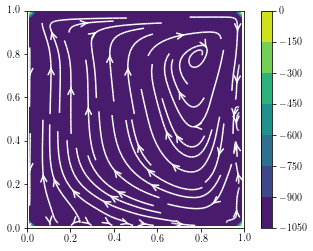

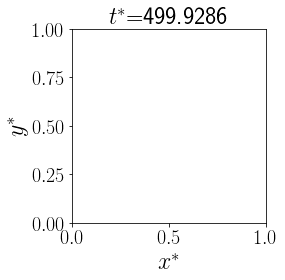

In [15]:
uc=np.array(np.zeros((Nx+1,Ny+1),dtype=np.float64))
vc=np.array(np.zeros((Nx+1,Ny+1),dtype=np.float64))
# interpolate
uc=0.5*(u[:,:-1]+u[:,1:])/Uwall # interpolate at the cell centre with scaling
vc=0.5*(v[:-1,:]+v[1:,:])/Uwall # interpolate at the cell centre with scaling

x2d, y2d = np.meshgrid(xc,yc)
# Controlling the starting points of the streamlines

seed_points = np.array([x2d[::4,::4].reshape(121), y2d[::4,::4].reshape(121)])
# 結果の図示
# plot streamlines and pressure field
fig_p, ax_p = plt.subplots()
tcf=ax_p.contourf(xc,yc,p)
fig_p.colorbar(tcf)
#ax_p.contour(xc,yc,p, colors='k')

#ax_p.streamplot(x2d,y2d,uc,vc,color='w',integration_direction='both',start_points=seed_points.T)
ax_p.streamplot(x2d,y2d,uc,vc,color='w',integration_direction='both',arrowsize=1.5,arrowstyle="->",
                minlength=0.2,maxlength=0.8,start_points=seed_points.T)

#ax_p.streamplot(x2d,y2d,uc,vc,color='w',density=0.7,integration_direction='both',arrowsize=1.5,arrowstyle="->")
#ax_p.streamplot(xc/Lx,yc/Lx,uc/Uwall,vc/Uwall,color='w',density=1,integration_direction='backward',arrowstyle="->")
ax_p.set_aspect('equal')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.show()
#fig_p.savefig(filename+'%04d'%ifield+'.png')

ax=plt.gca()
ax.set_title("$t^*$="+"{0:.4f}".format(itr*dt),fontsize=24)
ax.set_xlabel('$x^*$',fontsize=24)
ax.set_ylabel("$y^*$",fontsize=24)
ax.tick_params(labelsize=20)
ax.set_aspect('equal')
plt.tight_layout()

plt.show()

time elapsed:0.298804998398 sec., nstep=7304
